In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import json
from scipy import stats

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [ ]:
nombre_archivo = 'membresia_1_dia'
anio_ = 2025 # <--- CAMBIA ESTO POR TU ARCHIVO REAL

In [ ]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
nombre_archivo = f'../data/data_forecast_{anio_}/data_forecast_{anio_}_raw/ingresos_membresia_1_dia.csv'  # <--- CAMBIA ESTO POR TU ARCHIVO REAL
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")
print(f"Tipos de suscripción encontrados: {df_main['tipo_suscripcion'].unique()}")
display(df_main.head())

Rango de fechas: 2022-07-25 00:00:00 a 2025-12-03 00:00:00
Tipos de suscripción encontrados: ['1 Día (I.V.A incluido)' '3 Días (I.V.A incluido)'
 '7 Días (I.V.A incluido)' 'Anual (I.V.A incluido)'
 'Membresía Plus TEST 01 (IVA incluido)' 'Anual Ecobici+ (I.V.A incluido)'
 'Ecobici HSBC' 'ECOBICI vivo']


,anio,mes_numero,dia_numero,dia_semana,tipo_suscripcion,id_suscripcion,cantidad_Vendida,ingresos_totales_reales,fecha
0,2022,7,25,Monday,1 Día (I.V.A incluido),1,1,136.88,2022-07-25
1,2022,7,27,Wednesday,3 Días (I.V.A incluido),2,1,234.00,2022-07-27
2,2022,7,27,Wednesday,7 Días (I.V.A incluido),3,1,391.00,2022-07-27
3,2022,7,28,Thursday,1 Día (I.V.A incluido),1,3,354.00,2022-07-28
4,2022,7,28,Thursday,Anual (I.V.A incluido),4,1,521.00,2022-07-28


In [3]:
# eliminar columnas innecesarias si existen
columnas_a_eliminar = ['anio', 'mes_numero', 'dia_numero', 'dia_semana', 'tipo_suscripcion', 'id_suscripcion']  # Reemplaza con nombres reales
df_main = df_main.drop(columns=[col for col in columnas_a_eliminar if col in df_main.columns])
print("Columnas innecesarias eliminadas.")
df_main.head()

Columnas innecesarias eliminadas.


,cantidad_Vendida,ingresos_totales_reales,fecha
0,1,136.88,2022-07-25
1,1,234.00,2022-07-27
2,1,391.00,2022-07-27
3,3,354.00,2022-07-28
4,1,521.00,2022-07-28


### Deteccion de ouliers

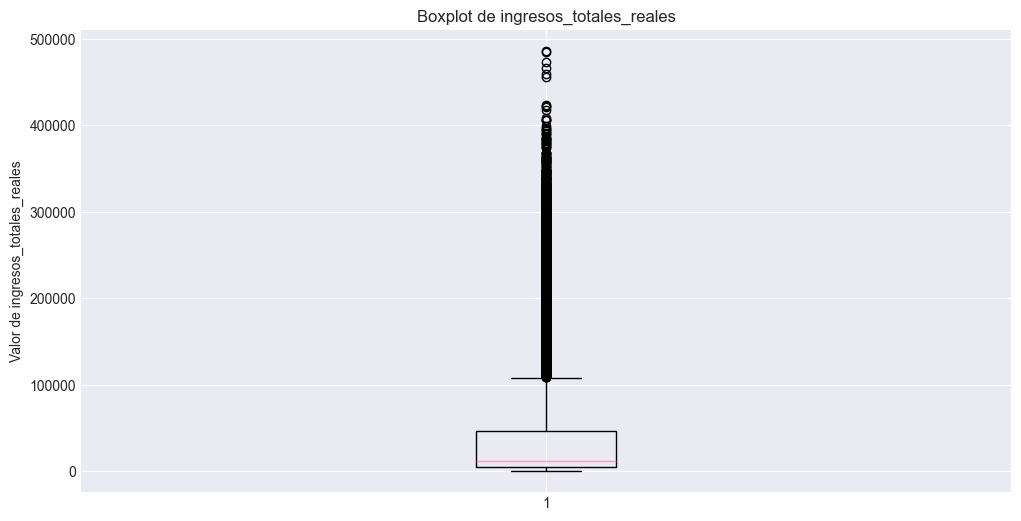

In [4]:
plt.figure(figsize=(12, 6))
plt.boxplot(df_main['ingresos_totales_reales'])
plt.title('Boxplot de ingresos_totales_reales')
plt.ylabel('Valor de ingresos_totales_reales')
plt.show()

In [5]:
# Calculando la mediana de los datos no extremos como valor de imputación
mediana = df_main['ingresos_totales_reales'].median()

# Calculando el IQR para identificar outliers
Q1 = df_main['ingresos_totales_reales'].quantile(0.25)
Q3 = df_main['ingresos_totales_reales'].quantile(0.75)
IQR = Q3 - Q1

# Definiendo los límites para identificar outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Imputando outliers con la mediana
df_main['ingresos_totales_reales_imputado'] = np.where(
    (df_main['ingresos_totales_reales'] < lower_limit) | (df_main['ingresos_totales_reales'] > upper_limit),
    mediana,  # Valor de imputación
    df_main['ingresos_totales_reales']  # Mantener el valor original si no es un outlier
)

In [6]:
# Mostrando el efecto de la imputación
print("Valores originales (con outliers):")
# print(df_main['ingresos_totales_reales'].describe())
df_main['ingresos_totales_reales'].describe()

Valores originales (con outliers):


count      5760.000000
mean      58479.577026
std       94892.676160
min         118.000000
25%        5463.890000
50%       11339.000000
75%       46576.282500
max      485895.090000
Name: ingresos_totales_reales, dtype: float64

In [7]:
print("\nValores después de la imputación de outliers:")
print(df_main['ingresos_totales_reales_imputado'].describe())


Valores después de la imputación de outliers:
count      5760.000000
mean      13427.806755
std       16026.632562
min         118.000000
25%        5463.890000
50%       11339.000000
75%       13080.967500
max      108069.890000
Name: ingresos_totales_reales_imputado, dtype: float64


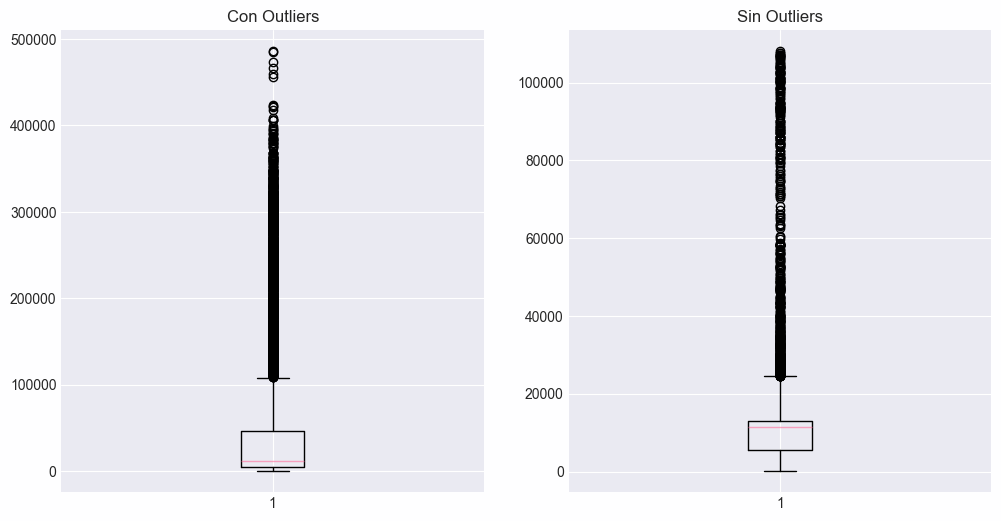

In [8]:
# Visualización de los datos con y sin outliers usando boxplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.boxplot(df_main['ingresos_totales_reales'])
plt.title('Con Outliers')

plt.subplot(1, 2, 2)
plt.boxplot(df_main['ingresos_totales_reales_imputado'])
plt.title('Sin Outliers')

plt.show()

In [9]:
df_main.describe()

,cantidad_Vendida,ingresos_totales_reales,fecha,ingresos_totales_reales_imputado
count,5760.000000,5760.000000,5760,5760.000000
mean,162.463021,58479.577026,2024-06-02 13:24:15,13427.806755
min,1.000000,118.000000,2022-07-25 00:00:00,118.000000
25%,11.000000,5463.890000,2023-08-04 00:00:00,5463.890000
50%,39.000000,11339.000000,2024-07-11 12:00:00,11339.000000
75%,242.250000,46576.282500,2025-04-08 00:00:00,13080.967500
max,2567.000000,485895.090000,2025-12-03 00:00:00,108069.890000
std,235.535590,94892.676160,NaN,16026.632562


In [ ]:
df_main.to_csv(f'../data/data_forecast_{anio_}/data_forecast_{anio_}_silver/numero_{nombre_archivo}_limpio.csv', index=False)
print(f"Dataset limpio guardado como 'numero_{nombre_archivo}_limpio.csv'.")

Dataset limpio guardado como 'ingresos_diaria_limpio.csv'.
